# Top 1000 YouTuber Popularity Analysis

## Data mining

In [3]:
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import pandas as pd
import seaborn as sns
import re
from datetime import datetime
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s


with open('google_api_key.txt', 'r') as file:
    api_key = file.readline()
YT = build("youtube", "v3", developerKey=api_key)

In [3]:
# read in the the script and extract the mapping of topic ids to categories and categories to supercategories
path = '/Users/masonhyz/Desktop/jsc370/jsc370/midterm project/topics.txt'
topic_id_to_category = {}
category_to_supercategory = {}
with open(path, 'r') as file:
    super = file.readline().strip()[:-7]
    line = file.readline().strip()
    while line:
        if line[0] == '/':
            id = line
            previous_is_id = True
        elif previous_is_id:
            topic_id_to_category[id] = line
            category_to_supercategory[line] = super
            previous_is_id = False
        else:
            super = line[:-7]
        line = file.readline().strip()

topic_id_to_category, category_to_supercategory

({'/m/04rlf': 'Music (parent topic)',
  '/m/02mscn': 'Christian music',
  '/m/0ggq0m': 'Classical music',
  '/m/01lyv': 'Country',
  '/m/02lkt': 'Electronic music',
  '/m/0glt670': 'Hip hop music',
  '/m/05rwpb': 'Independent music',
  '/m/03_d0': 'Jazz',
  '/m/028sqc': 'Music of Asia',
  '/m/0g293': 'Music of Latin America',
  '/m/064t9': 'Pop music',
  '/m/06cqb': 'Reggae',
  '/m/06j6l': 'Rhythm and blues',
  '/m/06by7': 'Rock music',
  '/m/0gywn': 'Soul music',
  '/m/0bzvm2': 'Gaming (parent topic)',
  '/m/025zzc': 'Action game',
  '/m/02ntfj': 'Action-adventure game',
  '/m/0b1vjn': 'Casual game',
  '/m/02hygl': 'Music video game',
  '/m/04q1x3q': 'Puzzle video game',
  '/m/01sjng': 'Racing video game',
  '/m/0403l3g': 'Role-playing video game',
  '/m/021bp2': 'Simulation video game',
  '/m/022dc6': 'Sports game',
  '/m/03hf_rm': 'Strategy video game',
  '/m/06ntj': 'Sports (parent topic)',
  '/m/0jm_': 'American football',
  '/m/018jz': 'Baseball',
  '/m/018w8': 'Basketball',
  '/

In [52]:
# mapping from category id to category
number_to_category = {24: "Entertainment", 
                      10: "Music",
                      20: "Gaming",
                      1: "Film & Animation",
                      25: "News & Politics",
                      22: "People & Blogs",
                      27: "Education",
                      23: "Comedy",
                      17: "Sports",
                      26: "Howto & Style",
                      28: "Science & Technology",
                      15: "Pets & Animals",
                      19: "Travel & Events",
                      }

### Supplementary data (getting the channel ids)

In [4]:
def getChannelID(link):
    """Using regex to extract channel id from link to channel"""
    pattern = r'youtube\.com/channel/([\w-]+)'
    match = re.search(pattern, link)
    return match.group(1)

In [5]:
def getChannelbyUsername(username):
    """get the channel response by username"""
    request = YT.channels().list(
        part='snippet,contentDetails,statistics,status,topicDetails',
        forUsername=username)
    response = request.execute()
    return response

In [6]:
def getChannelbyHandle(handle):
    """get the channel response by handle"""
    request = YT.channels().list(
        part='snippet,contentDetails,statistics,status,topicDetails',
        forHandle=handle)
    response = request.execute()
    return response

In [7]:
def getChannelbyID(id):
    """get the channel response by id"""
    request = YT.channels().list(
        part='snippet,contentDetails,statistics,status,topicDetails',
        forHandle=id)
    response = request.execute()
    return response

In [19]:
def getChannelResponse(id, username):
    """get the channel response by id and username if any matches"""
    response = getChannelbyID(id)
    length = len(response)
    if length != 4:
        response = getChannelbyUsername(username)
        length = len(response)
    if length != 4:
        return 0
    elif int(response['items'][0]['statistics']['subscriberCount']) > 1000000:
        return response
    else:
        return 0

In [ ]:
# Loading in supplementary data from Kaggle
supplementary_data = pd.read_csv('/Users/masonhyz/Downloads/youtubers_df.csv')
supplementary_data = supplementary_data[['Username', 'Links']]
supplementary_data['Channel ID'] = supplementary_data['Links'].apply(getChannelID)

In [21]:
# Extract channel infos from channel ids and usernames
supplementary_data["Channel INFO"] = supplementary_data.apply(lambda row: getChannelResponse(row["Channel ID"], row["Username"]), axis=1)
print("Channel responses extracted: ", (supplementary_data["Channel INFO"] != 0).sum())

Channel responses extracted:  245


### Channel data

In [34]:
def extractChannelInfo(response):
    """Extract channel statistics from channel response
    returns a tuple
    """
    channel_info = response['items'][0]
    id = channel_info['id']

    snippet = channel_info['snippet']
    username = snippet['title']
    description = snippet['description']
    handle = snippet['customUrl']
    published_at = datetime.strptime(snippet['publishedAt'], '%Y-%m-%dT%H:%M:%SZ')
    thumbnail_high = snippet['thumbnails']['high']['url']
    thumbnail_medium = snippet['thumbnails']['medium']['url']
    thumbnail_default = snippet['thumbnails']['default']['url']
    # country might be unknown
    country = snippet.get('country', np.nan)

    playlist_id = channel_info['contentDetails']['relatedPlaylists']['uploads']
    views = int(channel_info['statistics']['viewCount'])
    subscribers = int(channel_info['statistics']['subscriberCount'])
    hidden_subscriber_count = channel_info['statistics']['hiddenSubscriberCount']
    videos = int(channel_info['statistics']['videoCount'])
    is_public = channel_info['status']['privacyStatus'] == "public"
    is_linked = channel_info['status']['isLinked']
    long_uploads_status = channel_info['status']['longUploadsStatus']
    # made for kids might be unknown
    made_for_kids = channel_info['status'].get('madeForKids', np.nan)

    # topics might be unknown
    topic_details = channel_info.get('topicDetails', 'Unknown')
    if topic_details != "Unknown":
        topics_ids = topic_details['topicIds']
        topics = [topic_id_to_category[topic] for topic in topics_ids]
        topics_super = [category_to_supercategory[topic] for topic in topics]
        topics_super = list(dict.fromkeys(topics_super))
        topic_urls = topic_details['topicCategories']
    else: 
        topics, topics_super, topic_urls = np.nan, np.nan, np.nan

    return id, username, handle, subscribers, views, videos, country, description, published_at, topics, topics_super, topic_urls, made_for_kids, playlist_id, hidden_subscriber_count, is_public, is_linked, long_uploads_status, thumbnail_default, thumbnail_medium, thumbnail_high

In [27]:
# Constructing channel data
channel_data = supplementary_data.copy()
channel_data = channel_data[channel_data["Channel INFO"] != 0]
channel_data = channel_data[["Channel INFO"]]

In [30]:
# Extracting channel info into channel_data
channel_data["Id"], channel_data["username"], channel_data["handle"], channel_data["subscribers"], channel_data["views"], channel_data["videos"], channel_data["country"], channel_data["description"], channel_data["publishedAt"], channel_data["topics"], channel_data["topicsSuper"], channel_data["topicUrls"], channel_data["madeForKids"], channel_data["playlistId"], channel_data["hiddenSubscriberCount"], channel_data["isPublic"], channel_data["isLinked"], channel_data["longUploadsStatus"], channel_data["thumbnailDefault"], channel_data["thumbnailMedium"], channel_data["thumbnailHigh"] = zip(*channel_data.apply(lambda row: extractChannelInfo(row["Channel INFO"]), axis=1))

In [31]:
channel_data.info()
channel_data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, 3 to 998
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Channel INFO           245 non-null    object        
 1   Id                     245 non-null    object        
 2   username               245 non-null    object        
 3   handle                 245 non-null    object        
 4   subscribers            245 non-null    int64         
 5   views                  245 non-null    int64         
 6   videos                 245 non-null    int64         
 7   country                197 non-null    object        
 8   description            245 non-null    object        
 9   publishedAt            245 non-null    datetime64[ns]
 10  topics                 244 non-null    object        
 11  topicsSuper            244 non-null    object        
 12  topicUrls              244 non-null    object        
 13  madeForKid

,subscribers,views,videos,publishedAt
count,2.450000e+02,2.450000e+02,245.000000,245
mean,2.363780e+07,1.286447e+10,19753.946939,2010-03-08 09:30:13.077551104
min,1.140000e+06,0.000000e+00,0.000000,1970-01-01 00:00:00
25%,1.470000e+07,5.051928e+09,795.000000,2007-01-25 16:19:35
50%,1.820000e+07,8.790929e+09,2450.000000,2010-12-26 17:43:16
75%,2.600000e+07,1.625792e+10,7881.000000,2013-01-20 06:26:02
max,1.700000e+08,1.604211e+11,320658.000000,2014-12-14 02:07:35
std,1.760630e+07,1.504869e+10,49572.632807,NaN


### Video data

In [37]:
def get_videos(playlist_id):
    """get the first fifty video ids in a playlist, uncomment to get all"""
    request = YT.playlistItems().list(
        part='contentDetails',
        playlistId = playlist_id,
        maxResults = 50)
    response = request.execute()
    video_ids = []

    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])

    # next_page_token = response.get('nextPageToken')
    # more_pages = True

    # while more_pages:
    #     if next_page_token is None:
    #         more_pages = False
    #     else:
    #         request = YT.playlistItems().list(
    #             part='contentDetails',
    #             playlistId = playlist_id,
    #             maxResults = 50,
    #             pageToken = next_page_token)
    #         response = request.execute()
    
    #         for i in range(len(response['items'])):
    #             video_ids.append(response['items'][i]['contentDetails']['videoId'])
                
    #         next_page_token = response.get('nextPageToken' )
    return video_ids

In [36]:
def getVideoResponse(video_ids):
    """Get the all the video response from a list of video id,
    vectorized because extracting 50 videos cost only 1 quota
    """
    video_response = []
    for i in range(0, len(video_ids), 50):
        request = YT.videos().list(
            # can add other fields like ratings in the future
            part='snippet,statistics,contentDetails',
            id=','.join(video_ids[i:i+50]))
        response = request.execute()
        for video in response['items']:
            video_response.append(video)
    return video_response

In [41]:
def duration_to_seconds(duration):
    """Extract number of seconds from duration using regex"""
    # Define regular expression pattern to match duration
    pattern = r'PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?'
    # Match the pattern in the duration string
    match = re.match(pattern, duration)
    if not match:
        return np.nan

    # Extract hours, minutes, and seconds
    hours = int(match.group(1)) if match.group(1) else 0
    minutes = int(match.group(2)) if match.group(2) else 0
    seconds = int(match.group(3)) if match.group(3) else 0
    # Calculate total seconds
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds

In [42]:
def safe_to_int(x):
    if pd.isna(x):
        return x
    else:
        return int(x)
    
    
def extractVideoInfo(video):
    """extract the video statistics from a video response
    returns a dict instead of a tuple
    """
    content_details = video['contentDetails']

    duration = content_details.get('duration', 0)
    if isinstance(duration, tuple):
        duration = duration[0]
    if duration != 0:
        duration = duration_to_seconds(duration)
    
    thumbnail = video['snippet']['thumbnails'].get('maxres',np.nan),
    if isinstance(thumbnail, tuple):
        thumbnail = thumbnail[0]
    if not pd.isna(thumbnail):
        thumbnail = thumbnail['url']

    region_restriction = content_details.get('regionRestriction', np.nan)
    if not pd.isna(region_restriction):
        region_restriction = region_restriction.get("blocked", np.nan)

    video_stats = dict(
        channel = video['snippet']['channelTitle'],
        title = video['snippet']['title'],
        publishedDate = datetime.strptime(video['snippet']['publishedAt'], '%Y-%m-%dT%H:%M:%SZ'),
        views = int(video['statistics'].get('viewCount', 0)),
        likes = int(video['statistics'].get('likeCount', 0)),
        dislikes = int(video['statistics'].get('dislikeCount', 0)),
        comments = int(video['statistics'].get('commentCount', 0)),
        favorites = int(video['statistics'].get('favoriteCount', 0)),
        description = video['snippet'].get('description', np.nan),
        tags = video['snippet'].get('tags', np.nan),
        categoryId = safe_to_int(video['snippet'].get('categoryId', np.nan)),
        liveBroadcastContent = video['snippet'].get('liveBroadcaseContent', np.nan),
        thumbnail = thumbnail,
        durationSeconds = duration,
        dimension = content_details.get('dimension', np.nan),
        definition = content_details.get('definition', np.nan),
        caption = content_details.get('caption', np.nan) == 'true',
        licensedContent = content_details.get('lincensedContent', np.nan),
        regionRestriction = region_restriction,
        projection = content_details.get('projection', np.nan),
        )
    return video_stats

In [39]:
# aggregate all video ids
all_videos = []

for playlist in channel_data['playlistId']:
    try:
        videos = get_videos(playlist)
        if len(videos) <= 48:
            print("Not enough videos in playlist:", playlist)
        else:
            # leave behind the last two since they probably just posted
            all_videos.extend(videos[:-2])
    # handle http error
    except HttpError as e:
        if e.resp.status == 404:
            print("Playlist not found:", playlist)
        else:
            print("An error occurred while retrieving videos from playlist:", playlist)

print("Videos responses extracted: ", len(all_videos))


Playlist not found: UUuYZ-sFza5K_3GF0LyQAxjg
Videos responses extracted:  11712


In [40]:
# get all responses
all_video_responses = getVideoResponse(all_videos)

In [44]:
# get all statistics
all_video_infos = [extractVideoInfo(video) for video in all_video_responses]

In [50]:
# frame the data
video_data = pd.DataFrame(all_video_infos)

In [51]:
video_data.info()
video_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11712 entries, 0 to 11711
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   channel               11712 non-null  object        
 1   title                 11712 non-null  object        
 2   publishedDate         11712 non-null  datetime64[ns]
 3   views                 11712 non-null  int64         
 4   likes                 11712 non-null  int64         
 5   dislikes              11712 non-null  int64         
 6   comments              11712 non-null  int64         
 7   favorites             11712 non-null  int64         
 8   description           11712 non-null  object        
 9   tags                  9272 non-null   object        
 10  categoryId            11712 non-null  int64         
 11  liveBroadcastContent  0 non-null      float64       
 12  thumbnail             11378 non-null  object        
 13  durationSeconds 

,publishedDate,views,likes,dislikes,comments,favorites,categoryId,liveBroadcastContent,durationSeconds,licensedContent
count,11712,1.171200e+04,1.171200e+04,11712.0,11712.000000,11712.0,11712.000000,0.0,11674.000000,0.0
mean,2023-12-05 20:38:12.642332672,1.669593e+06,4.917956e+04,0.0,1530.934255,0.0,18.126622,NaN,1133.381360,NaN
min,2017-04-03 02:00:00,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,1.000000,NaN,4.000000,NaN
25%,2023-12-15 17:30:01.500000,2.330650e+04,3.687500e+02,0.0,5.000000,0.0,10.000000,NaN,56.000000,NaN
50%,2024-02-19 16:43:07.500000,1.222215e+05,3.236000e+03,0.0,80.000000,0.0,22.000000,NaN,236.000000,NaN
75%,2024-03-12 21:30:51,8.043242e+05,2.213500e+04,0.0,622.000000,0.0,24.000000,NaN,977.750000,NaN
max,2024-03-18 01:16:46,3.283409e+08,3.669311e+06,0.0,353160.000000,0.0,28.000000,NaN,42900.000000,NaN
std,NaN,8.287186e+06,1.746375e+05,0.0,7140.621891,0.0,7.700311,NaN,3172.480886,NaN


In [659]:
# save the two data frames
channel_data.to_csv('channels.csv', index=False, sep='\t', encoding='utf-8', na_rep='NA')
video_data.to_csv('videos.csv', index=False, sep='\t', encoding='utf-8', na_rep='NA')

## EDA

#### Subscribers vs. Views

In [53]:
transformed_data = channel_data.copy()

transformed_data['log_subscribers'] = np.log1p(transformed_data['subscribers'])
transformed_data['log_views'] = np.log1p(transformed_data['views'])
transformed_data['log_views'] = transformed_data['log_views'].replace(0, np.nan)

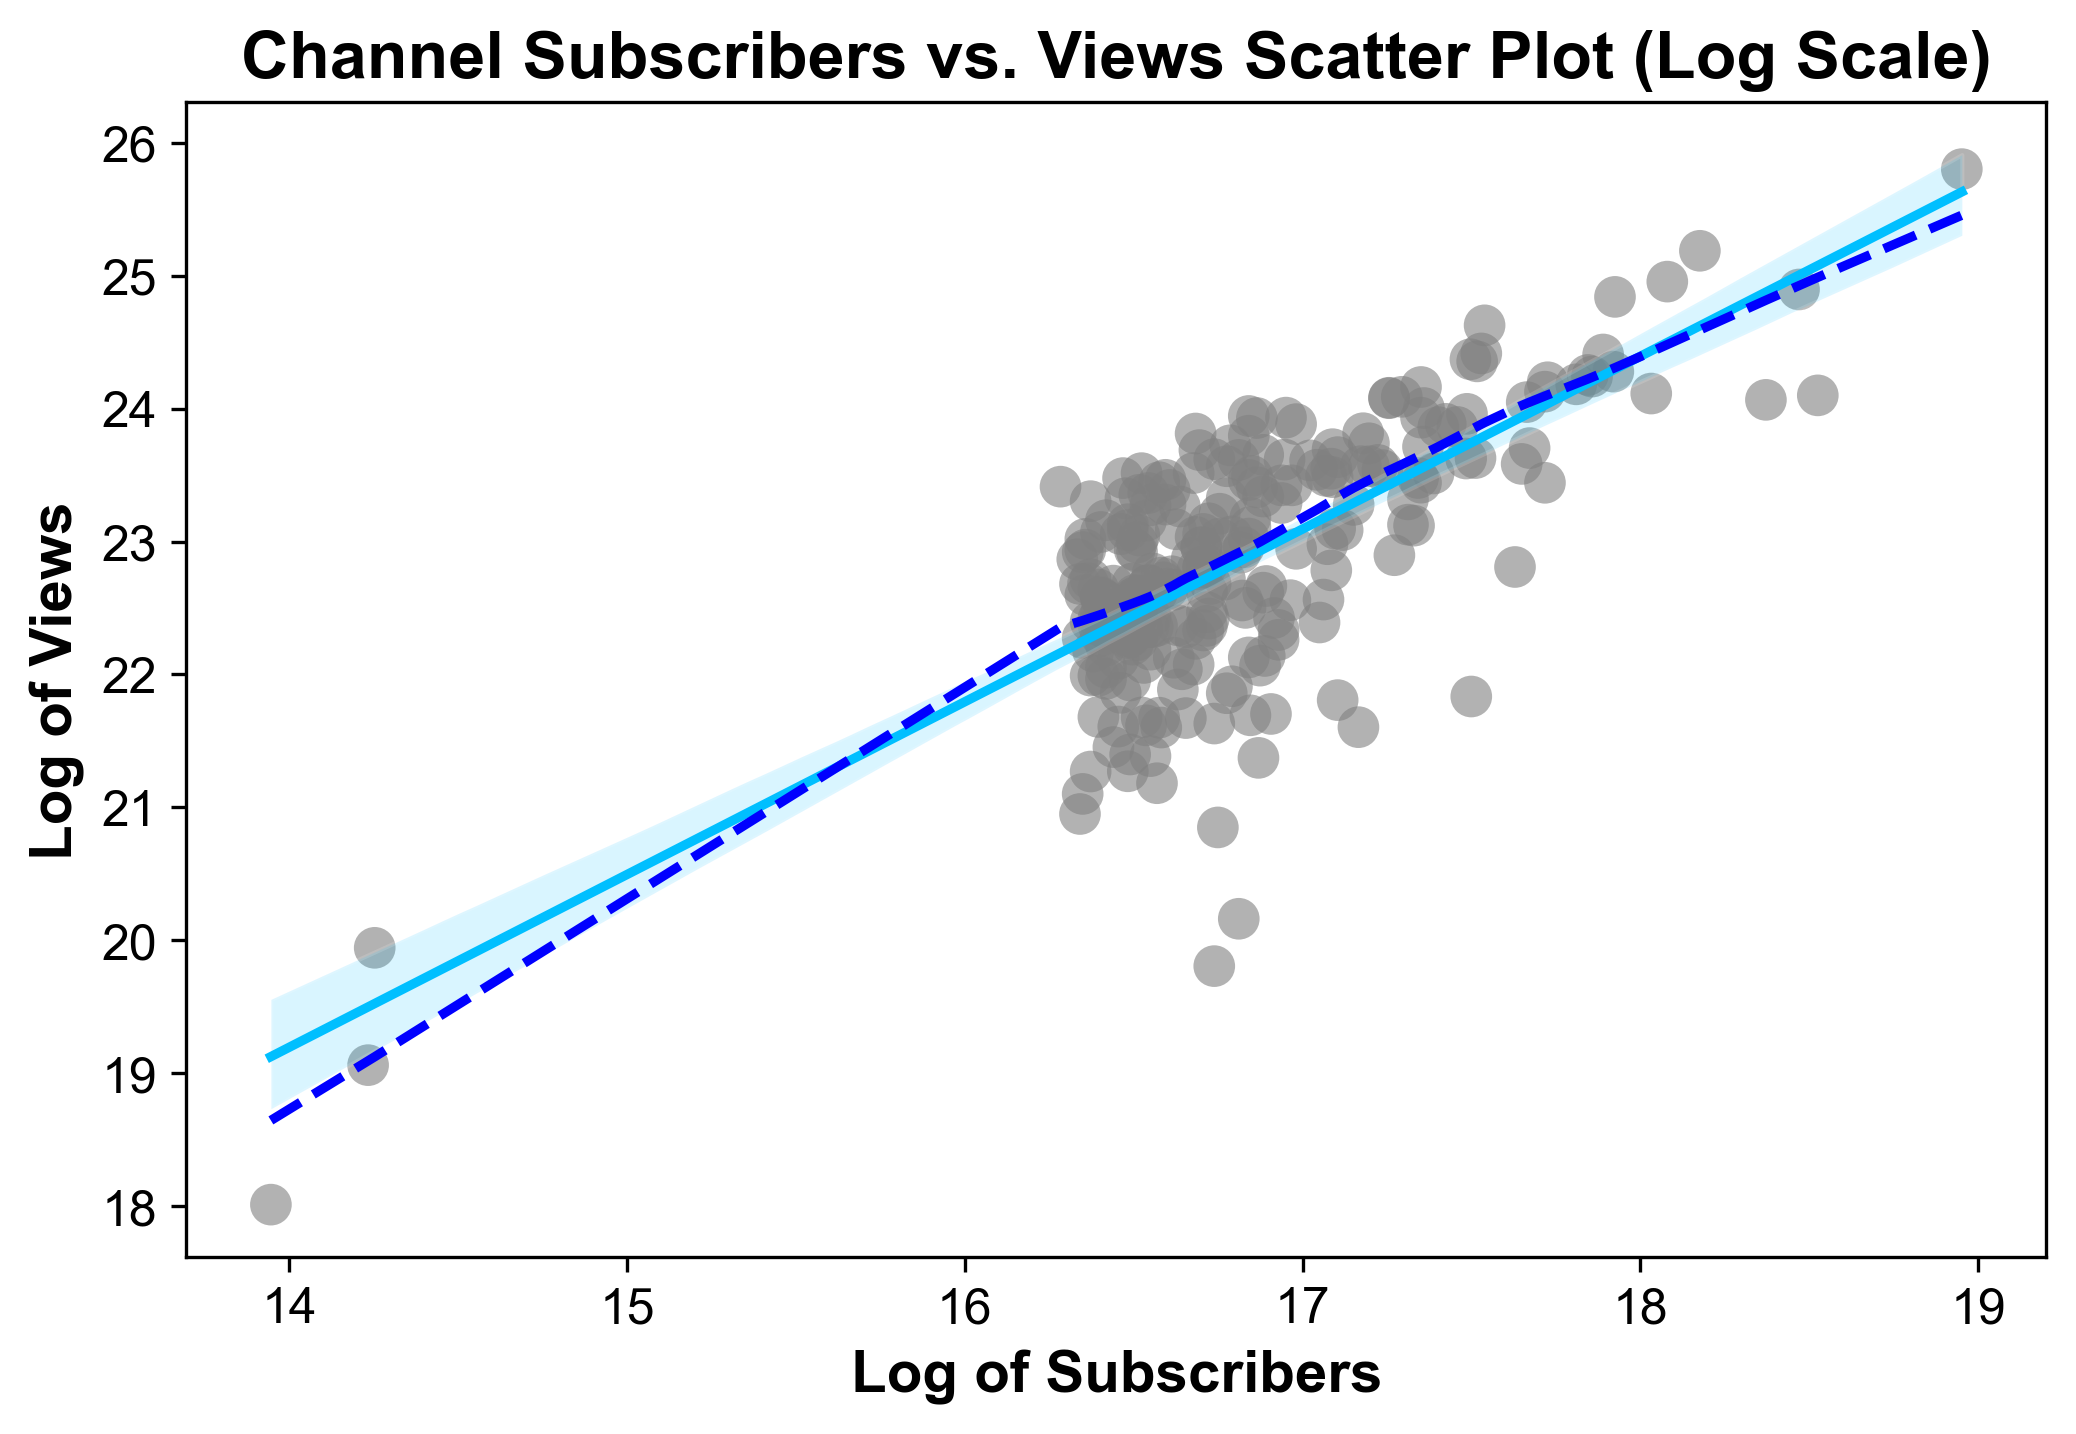

In [54]:
plt.figure(figsize=(8, 5), dpi=300)  # Setting figure size and resolution

# Creating the scatter plot with transformed data
sns.scatterplot(data=transformed_data, x='log_subscribers', y='log_views', alpha=0.6, color='grey', edgecolor='none', s=100)

# Adding a straight line through the points in log scale
sns.regplot(data=transformed_data, x='log_subscribers', y='log_views', scatter=False, line_kws={'color': 'deepskyblue'})

# Adding a lowess smooth dashed line through the points in log scale
sns.regplot(data=transformed_data, x='log_subscribers', y='log_views', lowess=True, scatter=False, line_kws={'color': 'blue', 'linestyle': '--'})

# Customizing the plot aesthetics
sns.set_style("whitegrid")
plt.xlabel('Log of Subscribers', fontsize=14, fontweight='bold')
plt.ylabel('Log of Views', fontsize=14, fontweight='bold')
plt.title('Channel Subscribers vs. Views Scatter Plot (Log Scale)', fontsize=16, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

#### Views vs. Category

In [55]:
category_avg_views = video_data.groupby('categoryId')['views'].mean().reset_index()
category_avg_views = category_avg_views.sort_values('views', ascending=False)
category_avg_views["categoryId"] = category_avg_views["categoryId"].map(number_to_category)

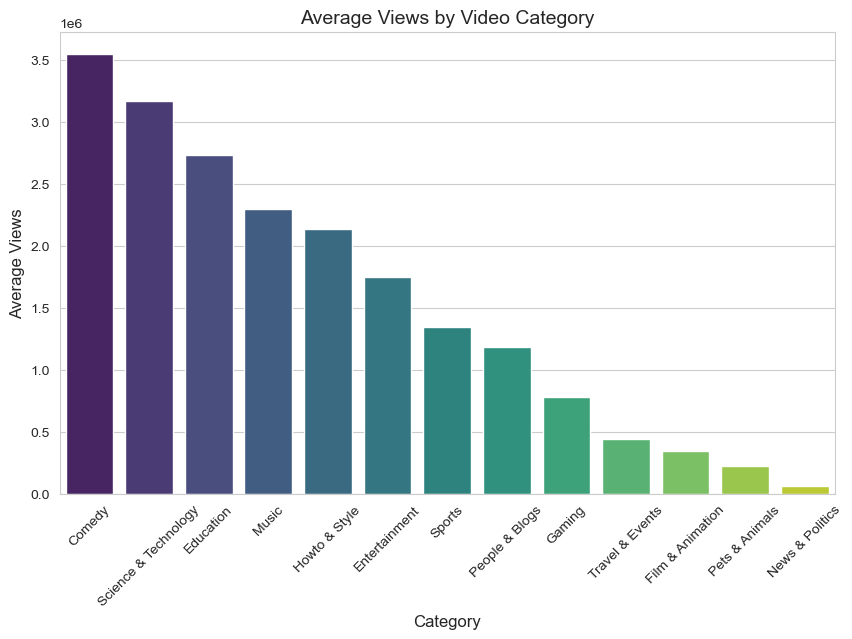

In [56]:
plt.figure(figsize=(10, 6))

# Creating a bar plot
sns.barplot(x='categoryId', y='views', data=category_avg_views, palette='viridis')

# Adding labels and title for clarity
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Views', fontsize=12)
plt.title('Average Views by Video Category', fontsize=14)

# Optionally, improve the aesthetics or readability
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

plt.show()

#### Views vs Day of Week

In [57]:
video_data['publish_day'] = video_data['publishedDate'].dt.day_name()
video_data['publish_hour'] = video_data['publishedDate'].dt.hour

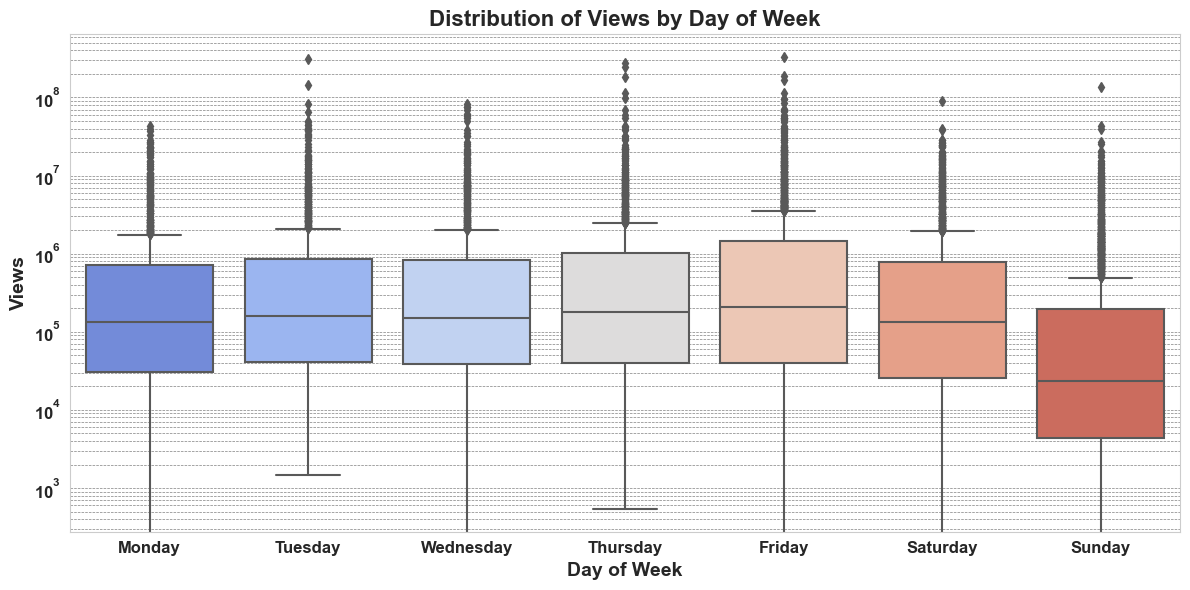

In [58]:
plt.figure(figsize=(12, 6))

# Assuming the order of days for better visualization
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Choose a color palette that you find more beautiful. Here, 'coolwarm' is used for illustration.
sns.boxplot(x='publish_day', y='views', data=video_data, order=order, palette='coolwarm')

plt.title('Distribution of Views by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=14, fontweight='bold')
plt.ylabel('Views', fontsize=14, fontweight='bold')

# Adjusting font sizes for the x and y tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Optionally, you can add grid lines for better readability
plt.grid(True, which="both", ls="--", linewidth=0.5, color='gray', axis='y')

# Tight layout often provides a cleaner look
plt.tight_layout()
plt.show()

#### GAM model

In [61]:
X = video_data[['comments', 'likes']]
y = video_data['views']
# Transforming y to a more manageable scale if necessary, e.g., log transformation
y_transformed = np.log1p(y)
# Fitting a GAM with default settings; you can customize splines and terms as needed
gam = LinearGAM(s(0) + s(1)).fit(X, y_transformed)

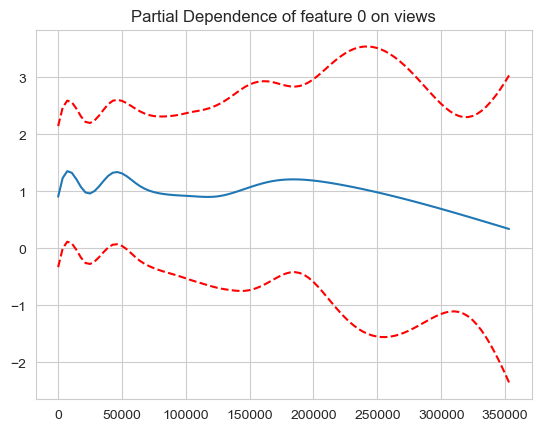

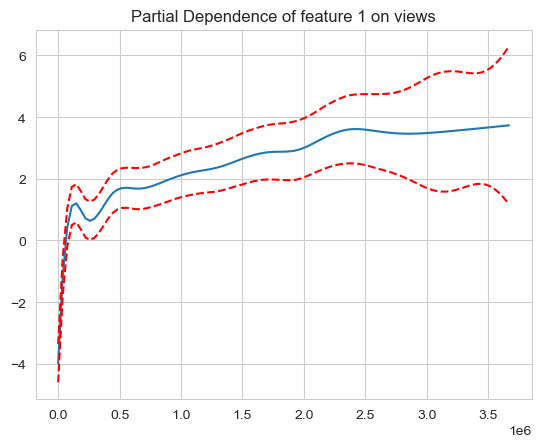

In [62]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, i], pdep)
    plt.plot(XX[:, i], confi, c='r', ls='--')
    plt.title(f'Partial Dependence of feature {i} on views')
    plt.show()